## Deep Backwards Stochastic Differential Equation

In [65]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### Implementing the Neural Network for $Z_\theta$ and $q_\theta$

We aim to solve the following stochastic optimal control problem using the **deep BSDE approach**.

---

#### Market Dynamics

- The mid-price evolves as:

$$
dP(t) = \left[ \mu^P + \psi(q(t)) \right] dt + \sigma^P\, dW^P(t)
$$

where $\psi(q) = \gamma q$ is the **permanent impact**.

- The residual demand evolves as:

$$
dD(t) = \rho\,\sigma^D\,dW^P(t) + \sqrt{1 - \rho^2}\,\sigma^D\,dW^D(t)
$$

- The imbalance price evolves as:

$$
dB(t) = \sigma^B\,dW^B(t)
$$

---

#### Execution Price and Running Cost

The execution price includes:
- Mid-price: $P(t)$
- Half-spread: $\operatorname{sign}(q(t)) \cdot \psi(q(t))$
- Temporary impact: $\phi(q(t)) = \eta q(t)$

The **execution price** is:

$$
\tilde{P}(t, q(t)) = P(t) + \operatorname{sign}(q(t)) \psi(q(t)) + \phi(q(t))
$$

The **running cost** is the negative of trading revenue:

$$
f(t, y, q) = -q(t)\cdot\tilde{P}(t, q(t))
$$

---

#### Terminal Cost

Let the imbalance be:

$$
I(T) = X(T) - D(T) + \xi
$$

The terminal cost is:

$$
h(y(T)) = -c_{\text{prod}} \cdot \xi + I(T)^+ \cdot B(T) - I(T)^- \cdot B(T)
$$

where $I^+ = \max(I, 0)$ and $I^- = \max(-I, 0)$.

In our implementation, we set $\xi = 0$ (no conventional production for now).

---

#### Deep BSDE Formulation

We solve the value function backward using:
- State dynamics: $d\boldsymbol{y}(t) = b(t) dt + \Sigma(t)\, dW(t)$
- Value function: $Y(t) = V(t, y(t))$
- Gradient process: $Z(t) = \Sigma(t)^\top \nabla_y V(t, y(t))$

The backward dynamics are:

$$
dY(t) = -f(t, y(t), q(t)) dt + Z(t)^\top dW(t)
$$

with terminal condition:

$$
Y(T) = h(y(T))
$$

We approximate:
- $Y(0)$ as a trainable parameter,
- $Z(t) \approx Z_\theta(t, y(t))$,
- $q(t) \approx q_\theta(t, y(t))$

and minimize the terminal mismatch:

$$
\mathbb{E} \left[ \left( Y(T) - h(y(T)) \right)^2 \right]
$$

This gives a trainable loss for the neural networks representing the value function and control.


In [64]:
# ========== Hyperparameters ==========
T = 1.0
N = 40
dt = T / N
batch_size = 256
dim = 4  # state = (X, P, D, B)

# ========== Model Parameters ==========
mu_P = 0.0
sigma_P = 0.2
sigma_D = 0.15
sigma_B = 0.3
rho = 0.3
gamma = 0.05  # permanent impact
eta = 0.1     # temporary impact
c_prod = 45.0  # production cost
xi = 0.0      # initial inventory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # output shape matches dW dim
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


class QNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


# ========== Impact Functions ==========
def psi(q): return gamma * q
def phi(q): return eta * q

# ========== Generator ==========
def generator(y, q):
    P = y[:, 1:2]  # mid-price
    sign_q = torch.sign(q)
    P_exec = P + sign_q * psi(q) + phi(q)
    return -q * P_exec  # shape: (batch, 1)

# ========== Terminal Cost ==========
def terminal_cost(y, X, D):
    B = y[:, 3:4]
    I = X - D + xi
    I_plus = torch.clamp(I, min=0.0)
    I_minus = torch.clamp(-I, min=0.0)
    return -c_prod * xi + I_plus * B - I_minus * B  # zero production for now

# ========== BSDE Solver ==========
class DeepBSDE(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], device=device))
        self.z_net = ZNetwork(state_dim).to(device)
        self.q_net = QNetwork(state_dim).to(device)

    def forward(self):
        # Initial state (X, P, D, B)
        y = torch.zeros(batch_size, dim, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        X, P, D, B = [torch.zeros(batch_size, 1, device=device) for _ in range(4)]

        Y = self.Y0.repeat(batch_size, 1)
        losses = []

        for i in range(N):
            t_input = t.clone()
            z = self.z_net(t_input, y)
            q = self.q_net(t_input, y)
            f = generator(y, q)

            dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
            dWP = dW[:, 0:1]
            dWD = dW[:, 1:2]
            dWB = dW[:, 2:3]

            # Forward SDE updates
            dX = q * dt
            dP = (mu_P + gamma * q) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)
            t += dt

        terminal = terminal_cost(y, X, D)
        loss = torch.mean((Y - terminal)**2)
        return loss


# ========== Training ==========
model = DeepBSDE(state_dim=dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.10f}")


Epoch 0: Loss = 0.0184397195
Epoch 50: Loss = 0.0002863439
Epoch 100: Loss = 0.0000855496
Epoch 150: Loss = 0.0000773146
Epoch 200: Loss = 0.0000482227
Epoch 250: Loss = 0.0000551215
Epoch 300: Loss = 0.0000432909
Epoch 350: Loss = 0.0000523233
Epoch 400: Loss = 0.0000464041
Epoch 450: Loss = 0.0000467018
Epoch 500: Loss = 0.0000390804
Epoch 550: Loss = 0.0000385911
Epoch 600: Loss = 0.0000497515
Epoch 650: Loss = 0.0000413125
Epoch 700: Loss = 0.0000363756
Epoch 750: Loss = 0.0000386858
Epoch 800: Loss = 0.0000338900
Epoch 850: Loss = 0.0000385538
Epoch 900: Loss = 0.0000384864
Epoch 950: Loss = 0.0000343260


### Training Loss

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Deep BSDE Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analysis of results

#### Optimal trading rate based on one simulation of the state

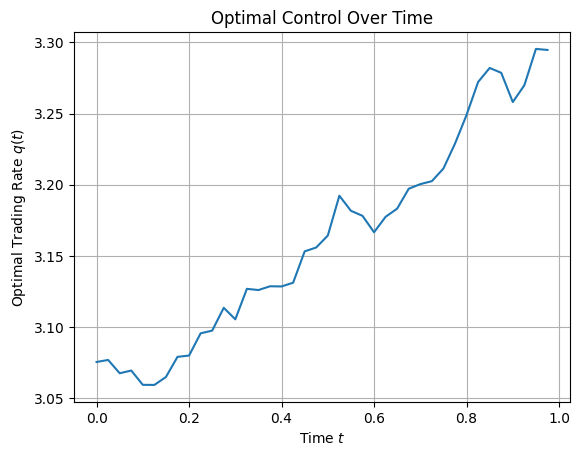

In [54]:
def simulate_control_path(model, y0=None, seed=42):
    torch.manual_seed(seed)
    model.eval()

    # Initial state
    if y0 is None:
        y = torch.tensor([[0.0, 50.0, 1.0, 45.0]], dtype=torch.float32, device=device)  # (X, P, D, B)
    else:
        y = y0.clone().to(device)

    X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
    t = torch.zeros(1, 1, device=device)

    q_traj = []
    t_traj = []

    for i in range(N):
        t_input = t.clone()
        q = model.q_net(t_input, y).detach().cpu().numpy()[0, 0]

        q_traj.append(q)
        t_traj.append(t.item())

        # Simulate forward SDE
        dW = torch.randn(1, 3, device=device) * np.sqrt(dt)
        dWP = dW[:, 0:1]
        dWD = dW[:, 1:2]
        dWB = dW[:, 2:3]

        dX = q * dt
        dP = (mu_P + gamma * q) * dt + sigma_P * dWP
        dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
        dB = sigma_B * dWB

        X = X + dX
        P = P + dP
        D = D + dD
        B = B + dB
        y = torch.cat([X, P, D, B], dim=1)
        t += dt

    return t_traj, q_traj

t_vals, q_vals = simulate_control_path(model, seed=np.random.randint(0, 100))

import matplotlib.pyplot as plt
plt.plot(t_vals, q_vals)
plt.xlabel("Time $t$")
plt.ylabel("Optimal Trading Rate $q(t)$")
plt.title("Optimal Control Over Time")
plt.grid(True)
plt.show()

#### Terminal State in imbalance price and imbalance position B(T) and I(T)

In [55]:
def sample_terminal_states(model, n_samples=1000):
    model.eval()
    X_list, D_list, B_list, I_list = [], [], [], []

    with torch.no_grad():
        for _ in range(n_samples // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
            t = torch.zeros(batch_size, 1, device=device)

            for _ in range(N):
                q = model.q_net(t, y)
                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP = dW[:, 0:1]
                dWT = dW[:, 1:2]
                dWB = dW[:, 2:3]

                dX = q * dt
                dP = (mu_P + gamma * q) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X = X + dX
                P = P + dP
                D = D + dD
                B = B + dB
                y = torch.cat([X, P, D, B], dim=1)
                t += dt

            I = X - D + xi
            X_list.append(X.cpu())
            D_list.append(D.cpu())
            B_list.append(B.cpu())
            I_list.append(I.cpu())

    return (
        torch.cat(X_list).squeeze().numpy(),
        torch.cat(D_list).squeeze().numpy(),
        torch.cat(B_list).squeeze().numpy(),
        torch.cat(I_list).squeeze().numpy()
    )


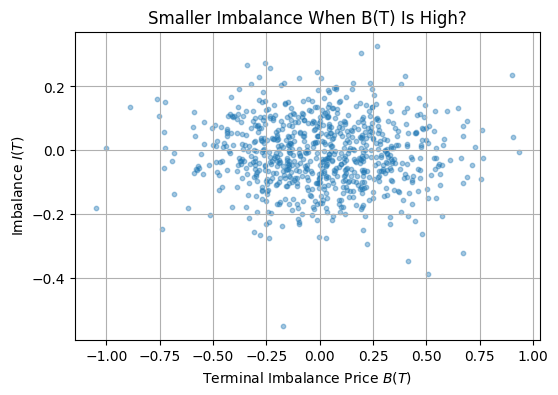

In [66]:
X_T, D_T, B_T, I_T = sample_terminal_states(model)

plt.figure(figsize=(6,4))
plt.scatter(B_T, I_T, alpha=0.4, s=10)
plt.xlabel("Terminal Imbalance Price $B(T)$")
plt.ylabel("Imbalance $I(T)$")
plt.title("Smaller Imbalance When B(T) Is High?")
plt.grid(True)
plt.show()


#### Correlation between X(T) and D(T)

In [ ]:
print("Correlation X(T) ~ D(T):", np.corrcoef(X_T, D_T)[0,1])

#### Optimal control for multiple simulations 

In [57]:
def simulate_multiple_control_trajectories(model, n_paths=1000):
    model.eval()
    n_steps = N
    all_qs = []

    with torch.no_grad():
        for _ in range(n_paths // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            t = torch.zeros(batch_size, 1, device=device)

            batch_qs = []

            for _ in range(n_steps):
                q = model.q_net(t, y).squeeze(-1)  # shape: (batch,)
                batch_qs.append(q.cpu().numpy())

                # simulate next state
                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP = dW[:, 0:1]
                dWT = dW[:, 1:2]
                dWB = dW[:, 2:3]

                q_reshaped = q.unsqueeze(-1)

                dX = q_reshaped * dt
                dP = (mu_P + gamma * q_reshaped) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
                X += dX
                P += dP
                D += dD
                B += dB
                y = torch.cat([X, P, D, B], dim=1)
                t += dt

            all_qs.append(np.stack(batch_qs, axis=0))  # shape: (T, batch)

    all_qs = np.concatenate(all_qs, axis=1)  # shape: (T, total_samples)
    return all_qs  # q values at each time step


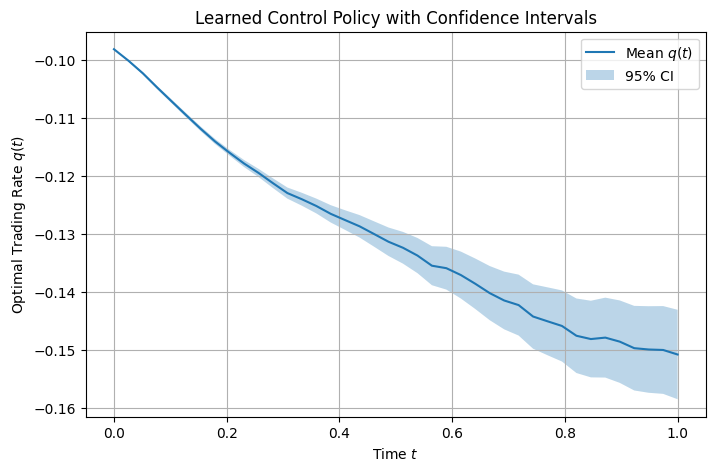

In [58]:
import matplotlib.pyplot as plt

all_qs = simulate_multiple_control_trajectories(model, n_paths=1000)
timesteps = np.linspace(0, T, N)

mean_q = all_qs.mean(axis=1)
std_q = all_qs.std(axis=1)
ci95 = 1.96 * std_q / np.sqrt(all_qs.shape[1])  # 95% CI

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean_q, label="Mean $q(t)$")
plt.fill_between(timesteps, mean_q - ci95, mean_q + ci95, alpha=0.3, label="95% CI")
plt.xlabel("Time $t$")
plt.ylabel("Optimal Trading Rate $q(t)$")
plt.title("Learned Control Policy with Confidence Intervals")
plt.grid(True)
plt.legend()
plt.show()


#### Optimal cost function for multiple simulations

In [61]:
def simulate_value_trajectories(model, n_paths=1000):
    model.eval()
    all_Y = []

    with torch.no_grad():
        for _ in range(n_paths // batch_size):
            y = torch.zeros(batch_size, dim, device=device)  # (X, P, D, B)
            X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
            t = torch.zeros(batch_size, 1, device=device)

            Y = model.Y0.repeat(batch_size, 1)
            Ys = []

            for _ in range(N):
                t_input = t.clone()
                z = model.z_net(t_input, y)
                q = model.q_net(t_input, y)
                f = generator(y, q)

                dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
                dWP, dWT, dWB = dW[:, 0:1], dW[:, 1:2], dW[:, 2:3]

                dX = q * dt
                dP = (mu_P + gamma * q) * dt + sigma_P * dWP
                dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
                dB = sigma_B * dWB

                X += dX
                P += dP
                D += dD
                B += dB
                y = torch.cat([X, P, D, B], dim=1)

                Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)
                Ys.append(Y.cpu().numpy())
                t += dt

            all_Y.append(np.stack(Ys, axis=0))  # shape: (T, batch)

    all_Y = np.concatenate(all_Y, axis=1)  # shape: (T, total_paths)
    return all_Y


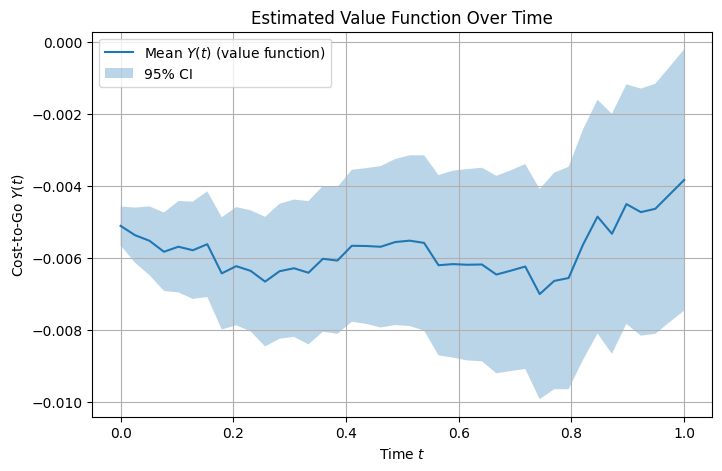

In [63]:
all_Y = simulate_value_trajectories(model, n_paths=1000)
timesteps = np.linspace(0, T, N)

mean_Y = all_Y.mean(axis=1).squeeze()
std_Y = all_Y.std(axis=1).squeeze()
ci95_Y = 1.96 * std_Y / np.sqrt(all_Y.shape[1])

plt.figure(figsize=(8,5))
plt.plot(timesteps, mean_Y, label="Mean $Y(t)$ (value function)")
plt.fill_between(timesteps, mean_Y - ci95_Y, mean_Y + ci95_Y, alpha=0.3, label="95% CI")
plt.xlabel("Time $t$")
plt.ylabel("Cost-to-Go $Y(t)$")
plt.title("Estimated Value Function Over Time")
plt.grid(True)
plt.legend()
plt.show()
